In [2]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys
import matplotlib.pyplot as plt

In [3]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
#from fun_objective_loop import constraint1
#from fun_objective_loop import constraint2
#from fun_objective_loop import constraint3

#input_name = sys.argv[1]
output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new)
    return total_cost_new

def objective3(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    return total_cost_new

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]





C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0
5229326166.565272
-------------epoch--------------
0
0
6064879667.898267
[0.         4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[1.13179277 4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
6002342921.871941
[0.16666667 4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[1.13179277 4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
5993729653.216031
[0.33333333 4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[1.13179277 4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
6028552408.758652
[0.5        4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[1.13179277 4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
5993461282.972401
[0.66666667 4.86652769 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[1.13179277 4.86652769 3.7

3496403572.966608
[2.         1.5        3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3505579186.267448
[2.         1.66666667 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3518174245.0658503
[2.         1.83333333 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3539293670.5290303
[2.         2.         3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3555695331.1337504
[2.         2.16666667 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 3.7117598  2.35882232 0.48231103 0.20918962
 4.6285107  1

3440768108.614925
[2.         1.33333333 3.16666667 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3457172108.614925
[2.         1.33333333 3.33333333 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3473576108.614925
[2.         1.33333333 3.5        2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3489980108.614925
[2.         1.33333333 3.66666667 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3506384108.614925
[2.         1.33333333 3.83333333 2.35882232 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 2.35882232 0.48231103 0.20918962
 4.6285107  1.26

3548146205.97
[2.         1.33333333 1.83333333 4.83333333 0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3564550205.97
[2.         1.33333333 1.83333333 5.         0.48231103 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.48231103 0.20918962
 4.6285107  1.26446932]
0
4052397737.4734445
[2.         1.33333333 1.83333333 0.16666667 0.         0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3647490515.5865717
[2.         1.33333333 1.83333333 0.16666667 0.16666667 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.48231103 0.20918962
 4.6285107  1.26446932]
0
3865078647.034403
[2.         1.33333333 1.83333333 0.16666667 0.33333333 0.20918962
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.48231103 0.20918962
 4.6285107  1.26446932

2471263988.3762364
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.33333333
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2503447991.9269333
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.5
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2536090788.2758684
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.66666667
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2568850071.0807905
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.83333333
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2601632715.374467
[2.         1.33333333 1.83333333 0.16666667 0.66666667 2.
 4.6285107  1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2634440715.3744664
[2.         1.33333333

2370887592.270114
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 3.5        1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2370887592.270114
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 3.66666667 1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2370887592.270114
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 3.83333333 1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2370887592.270114
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.         1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2370887592.270114
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.16666667 1.26446932]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.26446932]
0
2370887592.270114
[2.         1.33333333 1.83333333 0.16666667 0.66666

4940047298.796319
[0.5        1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
4947644269.00273
[0.66666667 1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
4568872732.6468935
[0.83333333 1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
4316987060.858092
[1.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
3858498123.938081
[1.16666667 1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.         1.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
3331278705.7257657
[1.33333333 1.33333333 1.83333333 0.16666667 0.6666

2481692087.5319166
[2.16666667 2.66666667 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2498096087.5319166
[2.16666667 2.83333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2514500087.5319166
[2.16666667 3.         1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2530904087.5319166
[2.16666667 3.16666667 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2547308087.5319166
[2.16666667 3.33333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 1.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2563712087.5319166
[2.16666667 3.5        1.83333333 0.16666667 0

2531356362.194543
[2.16666667 0.83333333 4.83333333 0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2547760362.194543
[2.16666667 0.83333333 5.         0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2305979847.3208256
[2.16666667 0.83333333 2.         0.         0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2236882974.1881423
[2.16666667 0.83333333 2.         0.16666667 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2243838327.291177
[2.16666667 0.83333333 2.         0.33333333 0.66666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.66666667 1.
 4.6285107  1.16666667]
0
2258799324.437322
[2.16666667 0.83333333 2.         0.5        0.666

2319498071.9756393
[2.16666667 0.83333333 2.         0.16666667 1.83333333 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2335902071.975639
[2.16666667 0.83333333 2.         0.16666667 2.         1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2352306071.9756393
[2.16666667 0.83333333 2.         0.16666667 2.16666667 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2368710071.9756393
[2.16666667 0.83333333 2.         0.16666667 2.33333333 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2385114071.975639
[2.16666667 0.83333333 2.         0.16666667 2.5        1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2401518071.9756393
[2.16666667 0.83333333 2.         0.16666667 2.6

0
2819627885.661061
[2.16666667 0.83333333 2.         0.16666667 0.83333333 4.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2852435885.661061
[2.16666667 0.83333333 2.         0.16666667 0.83333333 4.16666667
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2885243885.661061
[2.16666667 0.83333333 2.         0.16666667 0.83333333 4.33333333
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2918051885.661061
[2.16666667 0.83333333 2.         0.16666667 0.83333333 4.5
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2950859885.661061
[2.16666667 0.83333333 2.         0.16666667 0.83333333 4.66666667
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2983667885.661061
[2.16666667 0.83333333 2.

2303792701.9385858
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.        ]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2223976062.0257072
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2239677804.451585
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.33333333]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2257985230.5485144
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.5       ]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2276817859.330743
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.66666667]
[2.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2295682459.3307424
[2.16666667 0.83333333 2.         0.16666667 0.8

0
2323998654.5094275
[3.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2340402654.5094275
[3.33333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2356806654.5094275
[3.5        0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2373210654.5094275
[3.66666667 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2389614654.5094275
[3.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2406018654.5094275
[4.         0.83333333 2.         0.16666667

0
4607817414.302701
[1.83333333 0.83333333 0.16666667 0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
4624268708.904445
[1.83333333 0.83333333 0.33333333 0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
4640455968.222201
[1.83333333 0.83333333 0.5        0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
4649843919.77762
[1.83333333 0.83333333 0.66666667 0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
4626056943.939021
[1.83333333 0.83333333 0.83333333 0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
4470992632.663532
[1.83333333 0.83333333 1.         0.16666667 0.8333

2379344661.0200024
[1.83333333 0.83333333 2.         2.33333333 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2395748661.0200024
[1.83333333 0.83333333 2.         2.5        0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2412152661.0200024
[1.83333333 0.83333333 2.         2.66666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2428556661.0200024
[1.83333333 0.83333333 2.         2.83333333 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2444960661.0200024
[1.83333333 0.83333333 2.         3.         0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2461364661.0200024
[1.83333333 0.83333333 2.         3.16666667 0

0
2541204019.2095175
[1.83333333 0.83333333 2.         0.16666667 4.5        1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2557608019.209518
[1.83333333 0.83333333 2.         0.16666667 4.66666667 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2574012019.2095175
[1.83333333 0.83333333 2.         0.16666667 4.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2590416019.209518
[1.83333333 0.83333333 2.         0.16666667 5.         1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
3349276713.720058
[1.83333333 0.83333333 2.         0.16666667 0.83333333 0.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2883780360.0482216
[1.83333333 0.83333333 2.         0.16666667 0.

2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.5        1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.66666667 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.83333333 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 2.         1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 2.16666667 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333

0
2467714803.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  3.66666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2486579403.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  3.83333333]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2505444003.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  4.        ]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2524308603.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  4.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2543173203.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  4.33333333]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2562037803.9922547
[1.83333333 0.83333333 2.         0.16666667

3183785533.297361
[1.83333333 0.66666667 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2248681300.8744144
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2228025660.170591
[1.83333333 1.16666667 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2221204666.3652835
[1.83333333 1.33333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2225335797.4083714
[1.83333333 1.5        2.         0.16666667 0.83

2251203770.8801055
[1.83333333 0.83333333 2.83333333 0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2267422293.1178985
[1.83333333 0.83333333 3.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2283803974.1166883
[1.83333333 0.83333333 3.16666667 0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2300207974.116688
[1.83333333 0.83333333 3.33333333 0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2316611974.1166883
[1.83333333 0.83333333 3.5        0.16666667 0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2333015974.1166883
[1.83333333 0.83333333 3.66666667 0.16666667 0.

0
2641808661.0200024
[1.83333333 0.83333333 2.         5.         0.83333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
3747167788.1823807
[1.83333333 0.83333333 2.         0.16666667 0.         1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
3345688076.984308
[1.83333333 0.83333333 2.         0.16666667 0.16666667 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
3508012171.388814
[1.83333333 0.83333333 2.         0.16666667 0.33333333 1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2564478109.758046
[1.83333333 0.83333333 2.         0.16666667 0.5        1.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2224622141.3395705
[1.83333333 0.83333333 2.         0.16666667 0.

0
2392090962.199531
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2424898962.1995306
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.16666667
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2457706962.1995306
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.33333333
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2490514962.1995306
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.5
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2523322962.1995306
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.66666667
 4.6285107  1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2556130962.1995306
[1.83333333 0.833333

0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.16666667 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.33333333 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.5        1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.66666667 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.83333333 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 4.6285107  1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.833

5222623866.341612
[1.         1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5221673066.074236
[1.16666667 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5218536396.717759
[1.33333333 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5224439118.688514
[1.5        1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5233766932.21419
[1.66666667 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 1.39290064 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.161

0
5292072299.438031
[0.83333333 2.66666667 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5308476299.438031
[0.83333333 2.83333333 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5324880299.438031
[0.83333333 3.         0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5341284299.438031
[0.83333333 3.16666667 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5357688299.438031
[0.83333333 3.33333333 0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.68405947 1.02223571 4.84894476 1.41222812
 1.50011451 1.

0
5393190116.184169
[0.83333333 0.         4.33333333 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5409594116.184169
[0.83333333 0.         4.5        1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5425998116.184169
[0.83333333 0.         4.66666667 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5442402116.184169
[0.83333333 0.         4.83333333 1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
0
5458806116.184169
[0.83333333 0.         5.         1.02223571 4.84894476 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         1.02223571 4.84894476 1.41222812
 1.50011451 1.

4504845142.637849
new min
[0.83333333 0.         0.         0.16666667 0.83333333 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.41222812
 1.50011451 1.16158922]
0
4519814831.324114
[0.83333333 0.         0.         0.16666667 1.         1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.41222812
 1.50011451 1.16158922]
0
4535757095.507593
[0.83333333 0.         0.         0.16666667 1.16666667 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.41222812
 1.50011451 1.16158922]
0
4551675083.216556
[0.83333333 0.         0.         0.16666667 1.33333333 1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.41222812
 1.50011451 1.16158922]
0
4568140162.262652
[0.83333333 0.         0.         0.16666667 1.5        1.41222812
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.41222812
 1.50011

0
4752288527.733956
[0.83333333 0.         0.         0.16666667 0.83333333 2.66666667
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4785096527.733956
[0.83333333 0.         0.         0.16666667 0.83333333 2.83333333
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4817904527.733956
[0.83333333 0.         0.         0.16666667 0.83333333 3.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4850712527.733956
[0.83333333 0.         0.         0.16666667 0.83333333 3.16666667
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4883520527.733956
[0.83333333 0.         0.         0.16666667 0.83333333 3.33333333
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4916328527.733956
[0.83333333 0.    

0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 4.83333333 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 5.         1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
5552563372.70802
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 0.        ]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
5309549958.09136
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 0.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4826410369.044187
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 0.33333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4692166308.586601
[0.83333333 0.         0.         0.16666667 0.83333

0
4517427639.396822
[1.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4531691908.966213
[2.         0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4545900255.887578
[2.16666667 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4561970960.567094
[2.33333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4578268598.17274
[2.5        0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4594619870.760497
[2.66666667 0.         0.         0.16666667 0.8333

0
4825422384.273577
[0.83333333 4.16666667 0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4841826384.273577
[0.83333333 4.33333333 0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4858230384.273577
[0.83333333 4.5        0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4874634384.273577
[0.83333333 4.66666667 0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4891038384.273577
[0.83333333 4.83333333 0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4907442384.273578
[0.83333333 5.         0.         0.16666667 0.833

0
4515641068.581062
[0.83333333 0.         0.         1.16666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4532045068.581062
[0.83333333 0.         0.         1.33333333 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4548449068.581062
[0.83333333 0.         0.         1.5        0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4564853068.581062
[0.83333333 0.         0.         1.66666667 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4581257068.581062
[0.83333333 0.         0.         1.83333333 0.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4597661068.581062
[0.83333333 0.         0.         2.         0.833

0
4678408177.717683
[0.83333333 0.         0.         0.16666667 3.5        1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4694812177.717683
[0.83333333 0.         0.         0.16666667 3.66666667 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4711216177.717683
[0.83333333 0.         0.         0.16666667 3.83333333 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4727620177.717683
[0.83333333 0.         0.         0.16666667 4.         1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4744024177.717683
[0.83333333 0.         0.         0.16666667 4.16666667 1.
 1.50011451 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4760428177.717683
[0.83333333 0.         0.         0.16666667 4.333

0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.5        1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.66666667 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.83333333 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.         1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.16666667 1.16158922]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4420128490.194777
[0.83333333 0.         0.         0.16666667 0.833

4604630523.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 2.83333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4623495123.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 3.        ]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4642359723.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 3.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4661224323.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 3.33333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4680088923.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 3.5       ]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.50011451 1.16158922]
0
4698953523.828799
[0.83333333 0.         0.         0.16666667 0.83333

0
6516532749.408517
[4.5        4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
6532936749.408517
[4.66666667 4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
6549340749.408517
[4.83333333 4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
6565744749.408517
[5.         4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        4.47511241 0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
5877609369.242759
new min
[1.5        0.         0.86566434 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.86566434 0.82635088 0.44794224 4.68231756
 1.017

0
5890631810.640662
[1.5        0.         1.         0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
5906728212.923269
[1.5        0.         1.16666667 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
5923347440.757248
[1.5        0.         1.33333333 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
5939632363.746646
[1.5        0.         1.5        0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
0
5955953566.398327
[1.5        0.         1.66666667 0.82635088 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.82635088 0.44794224 4.68231756
 1.0172964  4.

0
5973028249.022381
[1.5        0.         0.         2.66666667 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.44794224 4.68231756
 1.0172964  4.86160428]
0
5989432249.022381
[1.5        0.         0.         2.83333333 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.44794224 4.68231756
 1.0172964  4.86160428]
0
6005836249.022381
[1.5        0.         0.         3.         0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.44794224 4.68231756
 1.0172964  4.86160428]
0
6022240249.022381
[1.5        0.         0.         3.16666667 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.44794224 4.68231756
 1.0172964  4.86160428]
0
6038644249.022381
[1.5        0.         0.         3.33333333 0.44794224 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.44794224 4.68231756
 1.0172964  4.

0
5964237168.682791
[1.5        0.         0.         0.         4.33333333 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.83333333 4.68231756
 1.0172964  4.86160428]
0
5980641168.682791
[1.5        0.         0.         0.         4.5        4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.83333333 4.68231756
 1.0172964  4.86160428]
0
5997045168.682791
[1.5        0.         0.         0.         4.66666667 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.83333333 4.68231756
 1.0172964  4.86160428]
0
6013449168.682791
[1.5        0.         0.         0.         4.83333333 4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.83333333 4.68231756
 1.0172964  4.86160428]
0
6029853168.682791
[1.5        0.         0.         0.         5.         4.68231756
 1.0172964  4.86160428]
[1.5        0.         0.         0.         0.83333333 4.68231756
 1.0172964  4.

0
4970696151.186798
[1.5        0.         0.         0.         0.83333333 1.
 1.16666667 4.86160428]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  4.86160428]
0
4970696151.186798
[1.5        0.         0.         0.         0.83333333 1.
 1.33333333 4.86160428]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  4.86160428]
0
4970696151.186798
[1.5        0.         0.         0.         0.83333333 1.
 1.5        4.86160428]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  4.86160428]
0
4970696151.186798
[1.5        0.         0.         0.         0.83333333 1.
 1.66666667 4.86160428]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  4.86160428]
0
4970696151.186798
[1.5        0.         0.         0.         0.83333333 1.
 1.83333333 4.86160428]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  4.86160428]
0
4970696151.186798
[1.5        0.         0.         0.         0.833

0
4797714831.109169
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  3.33333333]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4816579431.109169
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  3.5       ]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4835444031.109169
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  3.66666667]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4854308631.109169
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  3.83333333]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4873173231.109169
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  4.        ]
[1.5        0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4892037831.109169
[1.5        0.         0.         0.         0.833

0
4516143505.495809
[0.83333333 0.33333333 0.         0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4531764670.80309
[0.83333333 0.5        0.         0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4547269755.352476
[0.83333333 0.66666667 0.         0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4563284496.350563
[0.83333333 0.83333333 0.         0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4579485620.910299
[0.83333333 1.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4595815237.48912
[0.83333333 1.16666667 0.         0.         0.83333

0
4747097165.576072
[0.83333333 0.         2.66666667 0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4763501165.576072
[0.83333333 0.         2.83333333 0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4779905165.576072
[0.83333333 0.         3.         0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4796309165.576072
[0.83333333 0.         3.16666667 0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4812713165.576072
[0.83333333 0.         3.33333333 0.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.         0.83333333 1.
 1.0172964  1.16666667]
0
4829117165.576072
[0.83333333 0.         3.5        0.         0.833

0
4876786845.3239155
[0.83333333 0.         0.         4.83333333 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4893190845.3239155
[0.83333333 0.         0.         5.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4809982475.905159
[0.83333333 0.         0.         0.16666667 0.         1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4668934184.324486
[0.83333333 0.         0.         0.16666667 0.16666667 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4643286784.996929
[0.83333333 0.         0.         0.16666667 0.33333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4540079226.419965
[0.83333333 0.         0.         0.16666667 0.5

0
4588725124.180983
[0.83333333 0.         0.         0.16666667 0.83333333 1.83333333
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4621521904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 2.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4654329904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 2.16666667
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4687137904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 2.33333333
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4719945904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 2.5
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4752753904.230714
[0.83333333 0.         0.

0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 4.         1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 4.16666667 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 4.33333333 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 4.5        1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 4.66666667 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.833

0
4440897052.826718
[1.         0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4491919230.319201
[1.16666667 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4494582150.576822
[1.33333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4500993967.872571
[1.5        0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4514058041.179986
[1.66666667 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4517648414.028135
[1.83333333 0.         0.         0.16666667 0.833

0
4727260342.849036
[0.83333333 3.16666667 0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4743664342.849036
[0.83333333 3.33333333 0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4760068342.849036
[0.83333333 3.5        0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4776472342.849036
[0.83333333 3.66666667 0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4792876342.849036
[0.83333333 3.83333333 0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4809280342.849036
[0.83333333 4.         0.         0.16666667 0.833

0
4438889267.592873
[0.83333333 0.         0.         0.33333333 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4452071696.283474
[0.83333333 0.         0.         0.5        0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4467759733.366567
[0.83333333 0.         0.         0.66666667 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4483450526.703297
[0.83333333 0.         0.         0.83333333 0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4499538506.846885
[0.83333333 0.         0.         1.         0.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4515898845.3239155
[0.83333333 0.         0.         1.16666667 0.83

0
4580241099.850414
[0.83333333 0.         0.         0.16666667 2.5        1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4596645099.850414
[0.83333333 0.         0.         0.16666667 2.66666667 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4613049099.850414
[0.83333333 0.         0.         0.16666667 2.83333333 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4629453099.850414
[0.83333333 0.         0.         0.16666667 3.         1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4645857099.850414
[0.83333333 0.         0.         0.16666667 3.16666667 1.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4662261099.850414
[0.83333333 0.         0.         0.16666667 3.333

0
5146449904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 4.66666667
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
5179257904.230713
[0.83333333 0.         0.         0.16666667 0.83333333 4.83333333
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
5212065904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 5.
 1.0172964  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.         1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.16666667 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         

0
4472578323.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.66666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4491442923.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.83333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4510307523.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  2.        ]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4529172123.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  2.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4548036723.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  2.33333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.0172964  1.16666667]
0
4566901323.828799
[0.83333333 0.         0.         0.16666667 0.833

0
2918824972.5235367
[3.33333333 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2935228972.5235367
[3.5        4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2951632972.523536
[3.66666667 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2968036972.5235367
[3.83333333 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2984440972.5235367
[4.         4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 4.23719706 2.71943341 1.80032496 3.45861256 4.32986327
 1.1561441

0
2943111820.832721
[2.66666667 5.         2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
6093727325.098957
[2.66666667 1.66666667 0.         1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
6110021606.026386
[2.66666667 1.66666667 0.16666667 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
6126379111.625528
[2.66666667 1.66666667 0.33333333 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
6142656430.3807335
[2.66666667 1.66666667 0.5        1.80032496 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 1.80032496 3.45861256 4.32986327
 1.15614415 0

0
2589402676.1971636
[2.66666667 1.66666667 2.71943341 1.5        3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2605806676.1971636
[2.66666667 1.66666667 2.71943341 1.66666667 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2622210676.1971636
[2.66666667 1.66666667 2.71943341 1.83333333 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2638614676.1971636
[2.66666667 1.66666667 2.71943341 2.         3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 3.45861256 4.32986327
 1.15614415 0.7161588 ]
0
2655018676.197164
[2.66666667 1.66666667 2.71943341 2.16666667 3.45861256 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 3.45861256 4.32986327
 1.1561441

2497025373.5268145
[2.66666667 1.66666667 2.71943341 0.83333333 3.16666667 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        4.32986327
 1.15614415 0.7161588 ]
0
2513429373.5268145
[2.66666667 1.66666667 2.71943341 0.83333333 3.33333333 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        4.32986327
 1.15614415 0.7161588 ]
0
2529833373.526815
[2.66666667 1.66666667 2.71943341 0.83333333 3.5        4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        4.32986327
 1.15614415 0.7161588 ]
0
2546237373.5268145
[2.66666667 1.66666667 2.71943341 0.83333333 3.66666667 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        4.32986327
 1.15614415 0.7161588 ]
0
2562641373.526815
[2.66666667 1.66666667 2.71943341 0.83333333 3.83333333 4.32986327
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        4.32986327
 1.15614415 0

2465480941.60608
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        5.
 1.15614415 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 0.7161588 ]
0
1658981324.2472289
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 0.         0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 0.7161588 ]
0
1658981324.2472289
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 0.16666667 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 0.7161588 ]
0
1658981324.2472289
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 0.33333333 0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 0.7161588 ]
0
1658981324.2472289
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 0.5        0.7161588 ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 0.7161588 ]
0
1658981324.2472289
[2.66666667 1.66666667 2.71943341 0.83333333 1.5

1477649141.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 2.        ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1496513741.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 2.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1515378341.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 2.33333333]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1534242941.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 2.5       ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1553107541.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 2.66666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1571972141.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1

1531807067.6245954
[4.16666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1548211067.6245954
[4.33333333 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1564615067.6245954
[4.5        1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1581019067.6245954
[4.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1597423067.6245956
[4.83333333 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1613827067.6245954
[5.         1.66666667 2.71943341 0.83333333 1

4318064780.411223
[2.66666667 1.66666667 1.16666667 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
3656575643.103107
[2.66666667 1.66666667 1.33333333 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
3385622394.0762
[2.66666667 1.66666667 1.5        0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
3409331143.971962
[2.66666667 1.66666667 1.66666667 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
2474006173.1975274
[2.66666667 1.66666667 1.83333333 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
2030806987.9426064
[2.66666667 1.66666667 2.         0.83333333 1.5    

0
1630301834.4891984
[2.66666667 1.66666667 2.71943341 3.33333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1646705834.4891984
[2.66666667 1.66666667 2.71943341 3.5        1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1663109834.489199
[2.66666667 1.66666667 2.71943341 3.66666667 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1679513834.4891984
[2.66666667 1.66666667 2.71943341 3.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1695917834.4891984
[2.66666667 1.66666667 2.71943341 4.         1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1712321834.4891984
[2.66666667 1.66666667 2.71943341 4.16666667 

1868479079.0479016
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        0.33333333
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1680110090.206671
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        0.5
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1675519448.0748768
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        0.66666667
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1645726480.0255256
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        0.83333333
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1385995761.6247742
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1566187455.9736433
[2.66666667 1.66666667

1385995761.6247742
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 2.5        1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1385995761.6247742
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 2.66666667 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1385995761.6247742
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 2.83333333 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1385995761.6247742
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 3.         1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1385995761.6247742
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 3.16666667 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1385995761.6247742
[2.66666667 1.66666667 2.71943341 0.83333333 1

1779482741.9379268
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 4.66666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1798347341.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 4.83333333]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
0
1817211941.9379272
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 5.        ]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
[2.66666667 1.66666667 2.71943341 0.83333333 1.5        1.
 1.15614415 1.16666667]
Elapsed Time:  693.2519733905792 sec
0
2508794746.2200646
-------------epoch--------------
0
0
6285432953.896803
[0.         3.17493994 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[4.75221226 3.17493994 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
6091341926.2655325
[0.16666667 3.17493994 3.67739718 2.729927

2695131321.7623067
[2.66666667 1.         3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 3.17493994 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2475086942.415167
[2.66666667 1.16666667 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 3.17493994 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2438227817.3589673
[2.66666667 1.33333333 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 3.17493994 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2209399237.2449713
new min
[2.66666667 1.5        3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.5        3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2196901416.9531493
new min
[2.66666667 1.66666667 3.67739718 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 3.67739718 2.72992711 2.35100054 3.24473

2245180636.4822907
[2.66666667 1.66666667 2.66666667 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2115980699.669978
[2.66666667 1.66666667 2.83333333 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2130391467.6610596
[2.66666667 1.66666667 3.         2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2146633276.6251588
[2.66666667 1.66666667 3.16666667 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2163037276.625159
[2.66666667 1.66666667 3.33333333 2.72992711 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        2.72992711 2.35100054 3.24473682
 1.87531824 2

2267950993.9904156
[2.66666667 1.66666667 2.5        4.33333333 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2284354993.9904156
[2.66666667 1.66666667 2.5        4.5        2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2300758993.9904156
[2.66666667 1.66666667 2.5        4.66666667 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2317162993.9904156
[2.66666667 1.66666667 2.5        4.83333333 2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 2.35100054 3.24473682
 1.87531824 2.0127947 ]
0
2333566993.9904156
[2.66666667 1.66666667 2.5        5.         2.35100054 3.24473682
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 2.35100054 3.24473682
 1.87531824

1718678573.1530874
new min
[2.66666667 1.66666667 2.5        0.83333333 1.5        0.83333333
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        0.83333333
 1.87531824 2.0127947 ]
0
1481241527.0678596
new min
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1661008840.573538
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.16666667
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1561564721.906788
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.33333333
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1657281942.3738043
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.5
 1.87531824 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1532377169.464644


1481241527.0678596
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 2.83333333 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1481241527.0678596
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 3.         2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1481241527.0678596
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 3.16666667 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1481241527.0678596
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 3.33333333 2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1481241527.0678596
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 3.5        2.0127947 ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 2.0127947 ]
0
1481241527.0678596
[2.66666667 1.66666667 2.5        0.83333333 1

1819356125.3689373
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 5.        ]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
-------------epoch--------------
1
0
5226693628.453681
[0.         1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
5100625809.13032
[0.16666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
4967257148.377116
[0.33333333 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
5113056913.627256
[0.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.66666667 1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
5108608702.833273
[0.66666667 1.666

1407290968.356033
[2.5        2.         2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1423692119.1815898
[2.5        2.16666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1440096119.1815896
[2.5        2.33333333 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1456500119.1815896
[2.5        2.5        2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1472904119.1815898
[2.5        2.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1489308119.1815896
[2.5        2.83333333 2.5        0.83333333 1.

1639698925.2506173
[2.5        1.66666667 4.16666667 0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1656102925.2506175
[2.5        1.66666667 4.33333333 0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1672506925.2506177
[2.5        1.66666667 4.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1688910925.2506173
[2.5        1.66666667 4.66666667 0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1705314925.2506175
[2.5        1.66666667 4.83333333 0.83333333 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.83333333 1.5        1.
 1.87531824 1.16666667]
0
1721718925.2506177
[2.5        1.66666667 5.         0.83333333 1

1417862333.2301226
[2.5        1.66666667 2.5        0.66666667 1.16666667 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.5        1.
 1.87531824 1.16666667]
0
1345193830.3611753
new min
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1361206761.7924037
[2.5        1.66666667 2.5        0.66666667 1.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1377372987.6849787
[2.5        1.66666667 2.5        0.66666667 1.66666667 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1393682237.3385503
[2.5        1.66666667 2.5        0.66666667 1.83333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1410086237.3385503
[2.5        1.66666667 2.5        0.66

1859005062.1705024
[2.5        1.66666667 2.5        0.66666667 1.33333333 3.33333333
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1891813062.1705022
[2.5        1.66666667 2.5        0.66666667 1.33333333 3.5
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1924621062.1705027
[2.5        1.66666667 2.5        0.66666667 1.33333333 3.66666667
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1957429062.1705024
[2.5        1.66666667 2.5        0.66666667 1.33333333 3.83333333
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1990237062.1705022
[2.5        1.66666667 2.5        0.66666667 1.33333333 4.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
2023045062.170502
[2.5        1.66666667

0
1712407243.707666
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 0.33333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1564581183.137752
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 0.5       ]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1491116230.9459302
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1732928620.2439156
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 0.83333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1434249565.5640051
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.        ]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1

0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1352369096.9123306
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1369477328.6688647
[2.83333333 1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1385505043.0613449
[3.         1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1401909043.0613449
[3.16666667 1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1418313043.0613453
[3.33333333 1.66666667 2.5        0.66666667

0
1637169904.7398949
[2.5        4.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1653573904.7398949
[2.5        4.83333333 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1669977904.739895
[2.5        5.         2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
4795603965.005212
[2.5        1.66666667 0.         0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
4811990000.405247
[2.5        1.66666667 0.16666667 0.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
4828360897.746787
[2.5        1.66666667 0.33333333 0.66666667 1.3

0
1442272603.4210744
[2.5        1.66666667 2.5        1.66666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1458676603.4210744
[2.5        1.66666667 2.5        1.83333333 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1475080603.4210744
[2.5        1.66666667 2.5        2.         1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1491484603.4210744
[2.5        1.66666667 2.5        2.16666667 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1507888603.4210744
[2.5        1.66666667 2.5        2.33333333 1.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1524292603.4210744
[2.5        1.66666667 2.5        2.5       

0
1590530237.33855
[2.5        1.66666667 2.5        0.66666667 3.83333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1606934237.3385503
[2.5        1.66666667 2.5        0.66666667 4.         1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1623338237.3385506
[2.5        1.66666667 2.5        0.66666667 4.16666667 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1639742237.33855
[2.5        1.66666667 2.5        0.66666667 4.33333333 1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1656146237.3385503
[2.5        1.66666667 2.5        0.66666667 4.5        1.
 1.87531824 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1672550237.3385506
[2.5        1.66666667 2.5        0.66666667 4.6

1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 0.66666667 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 0.83333333 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.         1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.16666667 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.33333333 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1

0
1529226445.4486306
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 2.83333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1548091045.4486308
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 3.        ]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1566955645.4486303
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 3.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1585820245.4486306
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 3.33333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1604684845.4486308
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 3.5       ]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.87531824 1.16666667]
0
1623549445.4486303
[2.5        1.66666667 2.5        0.66666667

0
4421703188.064006
[4.5        3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4438107188.064006
[4.66666667 3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4454511188.064006
[4.83333333 3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4470915188.064006
[5.         3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
5851208401.401353
[1.83333333 0.         1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 3.72905962 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.

0
5619098197.0059805
[1.83333333 0.83333333 1.         0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
5255688158.029151
[1.83333333 0.83333333 1.16666667 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4647375701.423706
[1.83333333 0.83333333 1.33333333 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4445553780.383322
[1.83333333 0.83333333 1.5        0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4513964355.989339
[1.83333333 0.83333333 1.66666667 0.66519859 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.66519859 0.45112742 4.63349976
 0.69691832 0

0
4134949121.292252
[1.83333333 0.83333333 1.98704326 2.66666667 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4151353121.292252
[1.83333333 0.83333333 1.98704326 2.83333333 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4167757121.2922525
[1.83333333 0.83333333 1.98704326 3.         0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4184161121.2922525
[1.83333333 0.83333333 1.98704326 3.16666667 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.45112742 4.63349976
 0.69691832 0.29652673]
0
4200565121.292252
[1.83333333 0.83333333 1.98704326 3.33333333 0.45112742 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.45112742 4.63349976
 0.69691832 

0
3561217063.2565217
[1.83333333 0.83333333 1.98704326 0.16666667 4.33333333 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 4.63349976
 0.69691832 0.29652673]
0
3577621063.2565217
[1.83333333 0.83333333 1.98704326 0.16666667 4.5        4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 4.63349976
 0.69691832 0.29652673]
0
3594025063.2565217
[1.83333333 0.83333333 1.98704326 0.16666667 4.66666667 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 4.63349976
 0.69691832 0.29652673]
0
3610429063.2565217
[1.83333333 0.83333333 1.98704326 0.16666667 4.83333333 4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 4.63349976
 0.69691832 0.29652673]
0
3626833063.2565217
[1.83333333 0.83333333 1.98704326 0.16666667 5.         4.63349976
 0.69691832 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 4.63349976
 0.696918

0
2563382689.47057
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 1.16666667 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 0.29652673]
0
2563382689.47057
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 1.33333333 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 0.29652673]
0
2563382689.47057
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 1.5        0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 0.29652673]
0
2563382689.47057
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 1.66666667 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 0.29652673]
0
2563382689.47057
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 1.83333333 0.29652673]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 0.29652673]
0
2563382689.47057
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 

0
2462695975.936467
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 3.33333333]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2481560575.936467
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 3.5       ]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2500425175.936467
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 3.66666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2519289775.9364676
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 3.83333333]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2538154375.936467
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 4.        ]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2557018975.936467
[1.83333333 0.83333333 1.98704326 0.16666667 0.66

0
4052125140.8525677
[1.83333333 0.33333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
3635595332.967986
[1.83333333 0.5        1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
3213691607.319821
[1.83333333 0.66666667 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2221044589.881267
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2288502408.8391795
[1.83333333 1.         1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2262389572.1961007
[1.83333333 1.16666667 1.98704326 0.16666667 0.

0
2253015395.1611905
[1.83333333 0.83333333 2.5        0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2267981576.363464
[1.83333333 0.83333333 2.66666667 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2284008209.328816
[1.83333333 0.83333333 2.83333333 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2300230464.516645
[1.83333333 0.83333333 3.         0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2316612090.2876344
[1.83333333 0.83333333 3.16666667 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2333016090.2876344
[1.83333333 0.83333333 3.33333333 0.16666667 0.

0
2641096393.854446
[1.83333333 0.83333333 1.98704326 4.66666667 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2657500393.854446
[1.83333333 0.83333333 1.98704326 4.83333333 0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
2673904393.854446
[1.83333333 0.83333333 1.98704326 5.         0.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
3741222206.374577
[1.83333333 0.83333333 1.98704326 0.16666667 0.         1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
3340374791.1030254
[1.83333333 0.83333333 1.98704326 0.16666667 0.16666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.66666667 1.
 0.69691832 1.16666667]
0
3502496951.590122
[1.83333333 0.83333333 1.98704326 0.16666667 0.33

0
2322419464.713336
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.66666667
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2355913622.338777
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.83333333
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2388710335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 2.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2421518335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 2.16666667
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2454326335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 2.33333333
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2487134335.3955936
[1.83333333 0.

0
2185694985.4944115
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 3.83333333 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2185694985.4944115
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 4.         1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2185694985.4944115
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 4.16666667 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2185694985.4944115
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 4.33333333 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2185694985.4944115
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 4.5        1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2185694985.4944115
[1.83333333 0.83333333 1.98704326 0.16666667

0
4506973092.088522
[0.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
4267166503.891962
[1.         0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
3818117038.287999
[1.16666667 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
3300779699.831481
[1.33333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
3571278034.1638794
[1.5        0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
3198534175.646028
[1.66666667 0.83333333 1.98704326 0.16666667 0.83

0
2374000040.606635
[1.83333333 3.         1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2390404040.606635
[1.83333333 3.16666667 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2406808040.606635
[1.83333333 3.33333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2423212040.606635
[1.83333333 3.5        1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2439616040.606635
[1.83333333 3.66666667 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2456020040.606635
[1.83333333 3.83333333 1.98704326 0.16666667 0.833

0
2253431359.403307
[1.83333333 0.83333333 1.98704326 0.         0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2185694985.4944115
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2193568073.946285
[1.83333333 0.83333333 1.98704326 0.33333333 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2202272943.4700313
[1.83333333 0.83333333 1.98704326 0.5        0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2216109203.603067
[1.83333333 0.83333333 1.98704326 0.66666667 0.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2230447141.4129925
[1.83333333 0.83333333 1.98704326 0.83333333 0.

0
2308809686.9891744
[1.83333333 0.83333333 1.98704326 0.16666667 2.16666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2325213686.9891744
[1.83333333 0.83333333 1.98704326 0.16666667 2.33333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2341617686.9891744
[1.83333333 0.83333333 1.98704326 0.16666667 2.5        1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2358021686.9891744
[1.83333333 0.83333333 1.98704326 0.16666667 2.66666667 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2374425686.9891744
[1.83333333 0.83333333 1.98704326 0.16666667 2.83333333 1.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2390829686.9891744
[1.83333333 0.83333333 1.98704326 0.16666667

0
2848022335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 4.33333333
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2880830335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 4.5
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2913638335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 4.66666667
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2946446335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 4.83333333
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2979254335.3955936
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 5.
 0.69691832 1.16666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2185694985.4944115
[1.83333333 0.83333

0
2201394898.6679406
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.33333333]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2219701618.98888
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.5       ]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2238534203.2941704
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.66666667]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2257398803.2941704
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.83333333]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2276263403.2941704
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 2.        ]
[1.83333333 0.83333333 1.98704326 0.16666667 0.83333333 1.
 0.69691832 1.16666667]
0
2295128003.2941704
[1.83333333 0.83333333 1.98704326 0.16666667 0

0
5705291977.044687
[3.16666667 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5721695977.044687
[3.33333333 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5738099977.044687
[3.5        2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5754503977.044687
[3.66666667 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5770907977.044687
[3.83333333 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 2.01354212 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.

0
5868787913.17231
[1.83333333 4.83333333 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5885191913.17231
[1.83333333 5.         0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5550517942.227275
[1.83333333 0.83333333 0.         2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5566878017.549572
[1.83333333 0.83333333 0.16666667 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
0
5583320200.631
[1.83333333 0.83333333 0.33333333 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 0.95109371 2.85127863 4.75238898 2.92700239
 1.39876971 1.35317

2974667563.0424705
[1.83333333 0.83333333 2.         1.33333333 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 4.75238898 2.92700239
 1.39876971 1.35317982]
0
2991071563.0424705
[1.83333333 0.83333333 2.         1.5        4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 4.75238898 2.92700239
 1.39876971 1.35317982]
0
3007475563.0424705
[1.83333333 0.83333333 2.         1.66666667 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 4.75238898 2.92700239
 1.39876971 1.35317982]
0
3023879563.0424705
[1.83333333 0.83333333 2.         1.83333333 4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 4.75238898 2.92700239
 1.39876971 1.35317982]
0
3040283563.0424705
[1.83333333 0.83333333 2.         2.         4.75238898 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 4.75238898 2.92700239
 1.39876971

0
2730482811.5911846
[1.83333333 0.83333333 2.         0.16666667 3.         2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.92700239
 1.39876971 1.35317982]
0
2746886811.5911856
[1.83333333 0.83333333 2.         0.16666667 3.16666667 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.92700239
 1.39876971 1.35317982]
0
2763290811.5911846
[1.83333333 0.83333333 2.         0.16666667 3.33333333 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.92700239
 1.39876971 1.35317982]
0
2779694811.5911846
[1.83333333 0.83333333 2.         0.16666667 3.5        2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.92700239
 1.39876971 1.35317982]
0
2796098811.5911856
[1.83333333 0.83333333 2.         0.16666667 3.66666667 2.92700239
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 2.92700239
 1.398769

0
2903061303.3792214
[1.83333333 0.83333333 2.         0.16666667 0.83333333 4.83333333
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.35317982]
0
2935869303.3792214
[1.83333333 0.83333333 2.         0.16666667 0.83333333 5.
 1.39876971 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.35317982]
0
2206263952.23805
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 0.         1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.35317982]
0
2206263952.23805
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 0.16666667 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.35317982]
0
2206263952.23805
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 0.33333333 1.35317982]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.35317982]
0
2206263952.23805
[1.83333333 0.83333333 2.         0.16666667

0
2279068803.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 2.        ]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2297933403.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 2.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2316798003.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 2.33333333]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2335662603.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 2.5       ]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2354527203.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 2.66666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2373391803.9922547
[1.83333333 0.83333333 2.         0.16666667

0
2422422654.5094275
[4.16666667 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2438826654.5094275
[4.33333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2455230654.5094275
[4.5        0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2471634654.5094275
[4.66666667 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2488038654.5094275
[4.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2504442654.5094275
[5.         0.83333333 2.         0.16666667

0
4107678765.977002
[1.83333333 0.83333333 1.16666667 0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
3487756433.1560917
[1.83333333 0.83333333 1.33333333 0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
3270690885.8275385
[1.83333333 0.83333333 1.5        0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
3353161561.75355
[1.83333333 0.83333333 1.66666667 0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2305703989.690861
[1.83333333 0.83333333 1.83333333 0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83

0
2477768661.0200024
[1.83333333 0.83333333 2.         3.33333333 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2494172661.0200024
[1.83333333 0.83333333 2.         3.5        0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2510576661.0200024
[1.83333333 0.83333333 2.         3.66666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2526980661.0200024
[1.83333333 0.83333333 2.         3.83333333 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2543384661.0200024
[1.83333333 0.83333333 2.         4.         0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2559788661.020002
[1.83333333 0.83333333 2.         4.16666667 

0
2607899740.7891593
[1.83333333 0.83333333 2.         0.16666667 0.83333333 0.33333333
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2430700984.147598
[1.83333333 0.83333333 2.         0.16666667 0.83333333 0.5
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2446067231.449503
[1.83333333 0.83333333 2.         0.16666667 0.83333333 0.66666667
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2404321471.9112673
[1.83333333 0.83333333 2.         0.16666667 0.83333333 0.83333333
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2335746263.1414523
[1.83333333 0.83333333

0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 2.5        1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 2.66666667 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 2.83333333 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 3.         1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 3.16666667 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2188500338.395816
[1.83333333 0.83333333 2.         0.16666667 0.833

0
2580902403.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 4.66666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2599767003.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 4.83333333]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
0
2618631603.9922547
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 5.        ]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
[1.83333333 0.83333333 2.         0.16666667 0.83333333 1.
 1.39876971 1.16666667]
Elapsed Time:  860.7749483585358 sec
0
5580547999.926381
-------------epoch--------------
0
0
5617957836.946797
[0.         0.07714732 1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[4.56044166 0.07714732 1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
5425715129.26134
new min
[0.16666667 0.07714732 1.43295699 0

0
4130300991.6768584
new min
[1.5        1.         1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4144550298.0359874
[1.5        1.16666667 1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4154145490.637034
[1.5        1.33333333 1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4166459146.490832
[1.5        1.5        1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4181301091.055268
[1.5        1.66666667 1.43295699 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.43295699 0.30039389 2.74982215 2.55796813
 2.4

0
4241306239.3835783
[1.5        1.         2.66666667 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4256049512.229131
[1.5        1.         2.83333333 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4271529595.0635595
[1.5        1.         3.         0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4287821245.9120593
[1.5        1.         3.16666667 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4304225245.912059
[1.5        1.         3.33333333 0.30039389 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.30039389 2.74982215 2.55796813
 2.45625479

0
4404355073.556235
[1.5        1.         1.5        4.33333333 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4420759073.556235
[1.5        1.         1.5        4.5        2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4437163073.556235
[1.5        1.         1.5        4.66666667 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4453567073.556235
[1.5        1.         1.5        4.83333333 2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 2.74982215 2.55796813
 2.45625479 2.72694065]
0
4469971073.556235
[1.5        1.         1.5        5.         2.74982215 2.55796813
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 2.74982215 2.55796813
 2.45625479 2.

0
3799484207.308314
new min
[1.5        1.         1.5        0.16666667 0.83333333 0.83333333
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 0.83333333
 2.45625479 2.72694065]
0
3596500108.4212985
new min
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3743410781.181414
[1.5        1.         1.5        0.16666667 0.83333333 1.16666667
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3665911518.057114
[1.5        1.         1.5        0.16666667 0.83333333 1.33333333
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3771035408.6425886
[1.5        1.         1.5        0.16666667 0.83333333 1.5
 2.45625479 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3668141543.725109

0
3596500108.4212985
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.83333333 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3596500108.4212985
[1.5        1.         1.5        0.16666667 0.83333333 1.
 3.         2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3596500108.4212985
[1.5        1.         1.5        0.16666667 0.83333333 1.
 3.16666667 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3596500108.4212985
[1.5        1.         1.5        0.16666667 0.83333333 1.
 3.33333333 2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3596500108.4212985
[1.5        1.         1.5        0.16666667 0.83333333 1.
 3.5        2.72694065]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 2.72694065]
0
3596500108.4212985
[1.5        1.         1.5        0.16666667

0
3853782240.7518883
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 5.        ]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
-------------epoch--------------
1
0
4980309196.544206
[0.         1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4865158225.329543
[0.16666667 1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4739913327.153372
[0.33333333 1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4879329175.137265
[0.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.5        1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4877620759.8814945
[0.66666667 1

0
3309290068.0139985
[1.83333333 2.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3325692292.667849
[1.83333333 2.16666667 1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3342096292.667849
[1.83333333 2.33333333 1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3358500292.6678495
[1.83333333 2.5        1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3374904292.667849
[1.83333333 2.66666667 1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         1.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3391308292.667849
[1.83333333 2.83333333 1.5        0.16666667 0.8

0
2434921607.792281
[1.83333333 1.         4.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2451325607.792281
[1.83333333 1.         4.33333333 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2467729607.792281
[1.83333333 1.         4.5        0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2484133607.792281
[1.83333333 1.         4.66666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2500537607.792281
[1.83333333 1.         4.83333333 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2516941607.792281
[1.83333333 1.         5.         0.16666667 0.833

0
2275133170.1396317
[1.83333333 1.         2.         0.16666667 1.16666667 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2290255981.3288116
[1.83333333 1.         2.         0.16666667 1.33333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2305884257.7718806
[1.83333333 1.         2.         0.16666667 1.5        1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2321882449.3461456
[1.83333333 1.         2.         0.16666667 1.66666667 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2338182688.956426
[1.83333333 1.         2.         0.16666667 1.83333333 1.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2354586688.956426
[1.83333333 1.         2.         0.16666667 2

0
2713466934.260641
[1.83333333 1.         2.         0.16666667 0.83333333 3.33333333
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2746274934.260641
[1.83333333 1.         2.         0.16666667 0.83333333 3.5
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2779082934.260641
[1.83333333 1.         2.         0.16666667 0.83333333 3.66666667
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2811890934.260641
[1.83333333 1.         2.         0.16666667 0.83333333 3.83333333
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2844698934.260641
[1.83333333 1.         2.         0.16666667 0.83333333 4.
 2.45625479 1.16666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2877506934.2606406
[1.83333333 1.         2

0
2607001842.0337906
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 0.33333333]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2466787609.681439
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 0.5       ]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2361465700.838018
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 0.66666667]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2592227157.95535
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 0.83333333]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2328540521.3375463
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.        ]
[1.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2248681300.8744144
[1.83333333 1.         2.         0.16666667 0.8

0
1987457160.9166238
[2.5        1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2005993980.470592
[2.66666667 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2021364233.9568608
[2.83333333 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2037445941.4511983
[3.         1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2053849941.4511983
[3.16666667 1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2070253941.4511983
[3.33333333 1.         2.         0.16666667 

0
2249939365.644058
[2.         4.66666667 2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2266343365.644058
[2.         4.83333333 2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2282747365.6440587
[2.         5.         2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4654725106.737859
[2.         1.33333333 0.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4671023034.874435
[2.         1.33333333 0.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4687474283.21753
[2.         1.33333333 0.33333333 0.16666667 0.833

0
1745631387.0118763
[2.         1.33333333 2.16666667 1.66666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1762035387.011876
[2.         1.33333333 2.16666667 1.83333333 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1778439387.0118763
[2.         1.33333333 2.16666667 2.         0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1794843387.0118763
[2.         1.33333333 2.16666667 2.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1811247387.011876
[2.         1.33333333 2.16666667 2.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1827651387.0118763
[2.         1.33333333 2.16666667 2.5        0

0
1954853693.8408797
[2.         1.33333333 2.16666667 0.33333333 3.83333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1971257693.84088
[2.         1.33333333 2.16666667 0.33333333 4.         1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1987661693.84088
[2.         1.33333333 2.16666667 0.33333333 4.16666667 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
2004065693.8408797
[2.         1.33333333 2.16666667 0.33333333 4.33333333 1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
2020469693.84088
[2.         1.33333333 2.16666667 0.33333333 4.5        1.
 2.45625479 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
2036873693.84088
[2.         1.33333333 2.16666667 0.33333333 4.66666

0
1631140141.7714975
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 0.83333333 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1631140141.7714975
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 1.         1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1631140141.7714975
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 1.16666667 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1631140141.7714975
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 1.33333333 1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1631140141.7714975
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 1.5        1.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1631140141.7714975
[2.         1.33333333 2.16666667 0.33333333

0
1836611931.7567344
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 3.        ]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1855476531.7567344
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 3.16666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1874341131.7567341
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 3.33333333]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1893205731.7567344
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 3.5       ]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1912070331.7567341
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 3.66666667]
[2.         1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1930934931.7567344
[2.         1.33333333 2.16666667 0.33333333

0
4773662552.772552
[2.16666667 0.         2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
4635409815.514136
[2.16666667 0.16666667 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
4077304207.093153
[2.16666667 0.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
3650065377.1248326
[2.16666667 0.5        2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
3220780488.8451095
[2.16666667 0.66666667 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
2241479876.0522604
[2.16666667 0.83333333 2.16666667 0.33333333 0.

0
1471529684.1460207
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1576015204.7327032
[2.16666667 1.33333333 2.33333333 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1583879782.7374167
[2.16666667 1.33333333 2.5        0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1596288829.8900478
[2.16666667 1.33333333 2.66666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1610737088.2192144
[2.16666667 1.33333333 2.83333333 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
0
1633897340.1116958
[2.16666667 1.33333333 3.         0.33333333

0
1843158872.2449822
[2.16666667 1.33333333 2.16666667 4.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1859562872.2449827
[2.16666667 1.33333333 2.16666667 4.5        0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1875966872.2449822
[2.16666667 1.33333333 2.16666667 4.66666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1892370872.2449822
[2.16666667 1.33333333 2.16666667 4.83333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1908774872.2449827
[2.16666667 1.33333333 2.16666667 5.         0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3686497399.0960107
[2.16666667 1.33333333 2.16666667 0.16666667

0
1591694275.4797342
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.33333333
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1562165847.1191447
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.5
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1595168610.4609373
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.66666667
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1628659549.3943944
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.83333333
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1661456599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 2.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1694264599.4291546
[2.16666667 1.33333

0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 3.5        1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 3.66666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 3.83333333 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 4.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 4.16666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667

0
4929905308.232176
[0.5        1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4914328527.396959
[0.66666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4543076035.807544
[0.83333333 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
4301271716.657121
[1.         1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3832716760.487292
[1.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
3281750549.012547
[1.33333333 1.33333333 2.16666667 0.16666667 0.833

0
1575440480.9580956
[2.16666667 2.66666667 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1591844480.9580956
[2.16666667 2.83333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1608248480.9580956
[2.16666667 3.         2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1624652480.9580956
[2.16666667 3.16666667 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1641056480.9580956
[2.16666667 3.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1657460480.9580956
[2.16666667 3.5        2.16666667 0.16666667

0
1755463046.06531
[2.16666667 1.33333333 4.83333333 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1771867046.0653102
[2.16666667 1.33333333 5.         0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2141113268.879389
[2.16666667 1.33333333 2.16666667 0.         0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1471529684.1460207
[2.16666667 1.33333333 2.16666667 0.33333333 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1472613732.2833352
[2.16666667 1.33333333 2.16666667 0.5        0.

0
1588336218.0896945
[2.16666667 1.33333333 2.16666667 0.16666667 1.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1604740218.0896945
[2.16666667 1.33333333 2.16666667 0.16666667 2.         1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1621144218.0896945
[2.16666667 1.33333333 2.16666667 0.16666667 2.16666667 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1637548218.0896945
[2.16666667 1.33333333 2.16666667 0.16666667 2.33333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1653952218.0896945
[2.16666667 1.33333333 2.16666667 0.16666667 2.5        1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1670356218.0896945
[2.16666667 1.33333333 2.16666667 0.16666667

0
2055152599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 4.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2087960599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 4.16666667
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2120768599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 4.33333333
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2153576599.4291544
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 4.5
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2186384599.4291544
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 4.66666667
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
2219192599.4291544
[2.16666667 1.33333

0
1539884552.6168096
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.        ]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1475886018.2084963
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.33333333]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1494201820.0224469
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.5       ]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1513034979.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.66666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.45625479 1.16666667]
0
1531899579.5910168
[2.16666667 1.33333333 2.16666667 0.16666667

0
3239643049.3495226
[2.83333333 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
3178066037.68548
[3.         2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
3194470037.68548
[3.16666667 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
3210874037.685481
[3.33333333 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
3227278037.68548
[3.5        2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 2.36072339 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79

0
3382968054.202717
[2.66666667 4.5        4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
3399372054.2027164
[2.66666667 4.66666667 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
3415776054.202717
[2.66666667 4.83333333 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
3432180054.202717
[2.66666667 5.         4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
0
6429653454.851665
[2.66666667 1.66666667 0.         3.54357552 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 4.41532812 3.54357552 2.25863132 4.50554641
 1.22222322 0

0
2707521510.0489087
[2.66666667 1.66666667 2.5        1.         2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 2.25863132 4.50554641
 1.22222322 0.79149469]
0
2723961089.3149123
[2.66666667 1.66666667 2.5        1.16666667 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 2.25863132 4.50554641
 1.22222322 0.79149469]
0
2740365089.3149123
[2.66666667 1.66666667 2.5        1.33333333 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 2.25863132 4.50554641
 1.22222322 0.79149469]
0
2756769089.3149123
[2.66666667 1.66666667 2.5        1.5        2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 2.25863132 4.50554641
 1.22222322 0.79149469]
0
2773173089.3149123
[2.66666667 1.66666667 2.5        1.66666667 2.25863132 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 2.25863132 4.50554641
 1.222223

2720711667.73757
[2.66666667 1.66666667 2.5        0.66666667 2.66666667 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.50554641
 1.22222322 0.79149469]
0
2737115667.73757
[2.66666667 1.66666667 2.5        0.66666667 2.83333333 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.50554641
 1.22222322 0.79149469]
0
2753519667.73757
[2.66666667 1.66666667 2.5        0.66666667 3.         4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.50554641
 1.22222322 0.79149469]
0
2769923667.73757
[2.66666667 1.66666667 2.5        0.66666667 3.16666667 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.50554641
 1.22222322 0.79149469]
0
2786327667.73757
[2.66666667 1.66666667 2.5        0.66666667 3.33333333 4.50554641
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.50554641
 1.22222322 0.7914946

0
2557115646.7191195
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.33333333
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.79149469]
0
2589923646.7191195
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.5
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.79149469]
0
2622731646.7191195
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.66666667
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.79149469]
0
2655539646.7191195
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 4.83333333
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.79149469]
0
2688347646.7191195
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 5.
 1.22222322 0.79149469]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.79149469]


0
1669518031.9550946
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.83333333]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1669510128.4448354
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 1.        ]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1644066475.4754057
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 1.16666667]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1641948292.1487737
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 1.33333333]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1646605489.1278925
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 1.5       ]
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.222223

0
1526997284.3424094
new min
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1532811413.362418
[2.66666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1549120034.5693598
[2.83333333 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1565159195.379182
[3.         1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1581563195.3791819
[3.16666667 1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.

0
1770450576.4133105
[2.5        4.16666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1786854576.4133103
[2.5        4.33333333 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1803258576.4133105
[2.5        4.5        2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1819662576.4133105
[2.5        4.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1836066576.4133103
[2.5        4.83333333 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.222223

0
1526997284.3424094
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1534746876.6019404
[2.5        1.66666667 2.5        0.83333333 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1552143401.3324594
[2.5        1.66666667 2.5        1.         1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1568294646.0207307
[2.5        1.66666667 2.5        1.16666667 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1584698646.0207305
[2.5        1.66666667 2.5        1.33333333 1.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.222223

0
1621277316.0407636
[2.5        1.66666667 2.5        0.66666667 2.33333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1637681316.0407636
[2.5        1.66666667 2.5        0.66666667 2.5        0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1654085316.0407636
[2.5        1.66666667 2.5        0.66666667 2.66666667 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1670489316.0407636
[2.5        1.66666667 2.5        0.66666667 2.83333333 0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.22222322 0.66666667]
0
1686893316.0407636
[2.5        1.66666667 2.5        0.66666667 3.         0.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.66666667
 1.222223

0
2100656129.8669329
[2.5        1.66666667 2.5        0.66666667 1.33333333 4.16666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 0.66666667]
0
2133464129.8669333
[2.5        1.66666667 2.5        0.66666667 1.33333333 4.33333333
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 0.66666667]
0
2166272129.866933
[2.5        1.66666667 2.5        0.66666667 1.33333333 4.5
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 0.66666667]
0
2199080129.866933
[2.5        1.66666667 2.5        0.66666667 1.33333333 4.66666667
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 0.66666667]
0
2231888129.8669333
[2.5        1.66666667 2.5        0.66666667 1.33333333 4.83333333
 1.22222322 0.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 0.66666667]
0
2264696129.866933
[2.5        1.

0
1345193830.3611753
new min
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1360730040.411048
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.33333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1378371499.6345472
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.5       ]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1397174245.4486306
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1416038845.4486306
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.83333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1434903445.4486308
[2.5        1.66666667 2.5        0.6

1418313043.0613453
[3.33333333 1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1434717043.0613449
[3.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1451121043.0613449
[3.66666667 1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1467525043.0613453
[3.83333333 1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1483929043.0613449
[4.         1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1500333043.0613449
[4.16666667 1.66666667 2.5        0.66666667 1

0
4828360897.746787
[2.5        1.66666667 0.33333333 0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
4844652989.178982
[2.5        1.66666667 0.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
4847579938.287057
[2.5        1.66666667 0.66666667 0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
4813010106.844695
[2.5        1.66666667 0.83333333 0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
4655161029.077872
[2.5        1.66666667 1.         0.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
4261170741.651962
[2.5        1.66666667 1.16666667 0.66666667 1.333

0
1524292603.4210744
[2.5        1.66666667 2.5        2.5        1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1540696603.4210744
[2.5        1.66666667 2.5        2.66666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1557100603.4210744
[2.5        1.66666667 2.5        2.83333333 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1573504603.4210744
[2.5        1.66666667 2.5        3.         1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1589908603.4210744
[2.5        1.66666667 2.5        3.16666667 1.33333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1606312603.4210744
[2.5        1.66666667 2.5        3.33333333

0
1672550237.3385506
[2.5        1.66666667 2.5        0.66666667 4.66666667 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1688954237.33855
[2.5        1.66666667 2.5        0.66666667 4.83333333 1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1705358237.3385503
[2.5        1.66666667 2.5        0.66666667 5.         1.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
2678453426.766738
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
2203593798.0290046
[2.5        1.66666667 2.5        0.66666667 1.33333333 0.16666667
 1.22222322 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1834348278.543045
[2.5        1.66666667 2.5        0.6666

0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.5        1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.66666667 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.83333333 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 2.         1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 2.16666667 1.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1345193830.3611753
[2.5        1.66666667 2.5        0.66666667

0
1623549445.4486303
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 3.66666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1642414045.4486306
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 3.83333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1661278645.4486308
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 4.        ]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1680143245.4486303
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 4.16666667]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1699007845.4486306
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 4.33333333]
[2.5        1.66666667 2.5        0.66666667 1.33333333 1.
 1.22222322 1.16666667]
0
1717872445.4486308
[2.5        1.66666667 2.5        0.66666667

0
5501736171.158859
[0.33333333 0.16666667 0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5518140171.158859
[0.33333333 0.33333333 0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5534544171.15886
[0.33333333 0.5        0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5550948171.158859
[0.33333333 0.66666667 0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5567352171.158859
[0.33333333 0.83333333 0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.34274522 2.87129447 0.23402547 0.41620345
 1.7419656  4.6

0
5632041815.90193
[0.33333333 0.         1.83333333 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5648445815.90193
[0.33333333 0.         2.         2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5664849815.90193
[0.33333333 0.         2.16666667 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5681253815.90193
[0.33333333 0.         2.33333333 2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
0
5697657815.90193
[0.33333333 0.         2.5        2.87129447 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         2.87129447 0.23402547 0.41620345
 1.7419656  4.61760

0
5513571432.4447155
[0.33333333 0.         0.         3.5        0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.23402547 0.41620345
 1.7419656  4.61760548]
0
5529975432.4447155
[0.33333333 0.         0.         3.66666667 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.23402547 0.41620345
 1.7419656  4.61760548]
0
5546379432.4447155
[0.33333333 0.         0.         3.83333333 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.23402547 0.41620345
 1.7419656  4.61760548]
0
5562783432.4447155
[0.33333333 0.         0.         4.         0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.23402547 0.41620345
 1.7419656  4.61760548]
0
5579187432.4447155
[0.33333333 0.         0.         4.16666667 0.23402547 0.41620345
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.23402547 0.41620345
 1.741965

0
5869999679.255551
[0.33333333 0.         0.         0.         0.66666667 0.
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.66666667 0.41620345
 1.7419656  4.61760548]
0
5414882586.964972
[0.33333333 0.         0.         0.         0.66666667 0.16666667
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.66666667 0.41620345
 1.7419656  4.61760548]
0
5157401679.960008
[0.33333333 0.         0.         0.         0.66666667 0.33333333
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.66666667 0.41620345
 1.7419656  4.61760548]
0
5044490549.159184
new min
[0.33333333 0.         0.         0.         0.66666667 0.5
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.66666667 0.5
 1.7419656  4.61760548]
0
5005277424.117056
new min
[0.33333333 0.         0.         0.         0.66666667 0.66666667
 1.7419656  4.61760548]
[0.33333333 0.         0.         0.         0.66666667 0.66666667
 1.7419656  4.617605

0
4900607062.354479
[0.33333333 0.         0.         0.         0.66666667 1.
 2.         4.61760548]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.61760548]
0
4900607062.354479
[0.33333333 0.         0.         0.         0.66666667 1.
 2.16666667 4.61760548]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.61760548]
0
4900607062.354479
[0.33333333 0.         0.         0.         0.66666667 1.
 2.33333333 4.61760548]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.61760548]
0
4900607062.354479
[0.33333333 0.         0.         0.         0.66666667 1.
 2.5        4.61760548]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.61760548]
0
4900607062.354479
[0.33333333 0.         0.         0.         0.66666667 1.
 2.66666667 4.61760548]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.61760548]
0
4900607062.354479
[0.33333333 0.         0.         0.         0.666

0
4849566380.432984
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.16666667]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4868430980.432984
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.33333333]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4887295580.432984
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.5       ]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4906160180.432984
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.66666667]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4925024780.432984
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  4.83333333]
[0.33333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4943889380.432984
[0.33333333 0.         0.         0.         0.666

0
4603381576.293757
[0.83333333 1.16666667 0.         0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4619781695.157048
[0.83333333 1.33333333 0.         0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4636185695.157048
[0.83333333 1.5        0.         0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4652589695.157048
[0.83333333 1.66666667 0.         0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4668993695.157048
[0.83333333 1.83333333 0.         0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4685397695.157048
[0.83333333 2.         0.         0.         0.666

0
4837689406.822328
[0.83333333 0.         3.5        0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4854093406.822328
[0.83333333 0.         3.66666667 0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4870497406.822328
[0.83333333 0.         3.83333333 0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4886901406.822328
[0.83333333 0.         4.         0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4903305406.822328
[0.83333333 0.         4.16666667 0.         0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.         0.66666667 1.
 1.7419656  1.16666667]
0
4919709406.822328
[0.83333333 0.         4.33333333 0.         0.666

0
4540079226.419965
[0.83333333 0.         0.         0.16666667 0.5        1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.66666667 1.
 1.7419656  1.16666667]
0
4461841318.799966
[0.83333333 0.         0.         0.16666667 0.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.66666667 1.
 1.7419656  1.16666667]
0
4420384580.975293
new min
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4435107867.567235
[0.83333333 0.         0.         0.16666667 1.         1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4449992710.569449
[0.83333333 0.         0.         0.16666667 1.16666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4465704777.097657
[0.83333333 0.         0.         0.166666

0
4752753904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 2.66666667
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4785561904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 2.83333333
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4818369904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 3.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4851177904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 3.16666667
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4883985904.230714
[0.83333333 0.         0.         0.16666667 0.83333333 3.33333333
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4916793904.230714
[0.83333333 0.    

0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 4.83333333 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 5.         1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
5552563372.70802
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  0.        ]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
5309549958.09136
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  0.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4826410369.044187
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  0.33333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4692166308.586601
[0.83333333 0.         0.         0.16666667 0.83333

0
4517648414.028135
[1.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4531912680.986911
[2.         0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4546121060.776319
[2.16666667 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4562191789.639816
[2.33333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4578489444.159674
[2.5        0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4594840729.382087
[2.66666667 0.         0.         0.16666667 0.833

0
4809280342.849036
[0.83333333 4.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4825684342.849036
[0.83333333 4.16666667 0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4842088342.849036
[0.83333333 4.33333333 0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4858492342.849036
[0.83333333 4.5        0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4874896342.849036
[0.83333333 4.66666667 0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4891300342.849036
[0.83333333 4.83333333 0.         0.16666667 0.833

0
4515898845.3239155
[0.83333333 0.         0.         1.16666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4532302845.3239155
[0.83333333 0.         0.         1.33333333 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4548706845.3239155
[0.83333333 0.         0.         1.5        0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4565110845.3239155
[0.83333333 0.         0.         1.66666667 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4581514845.3239155
[0.83333333 0.         0.         1.83333333 0.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4597918845.3239155
[0.83333333 0.         0.         2.        

0
4662261099.850414
[0.83333333 0.         0.         0.16666667 3.33333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4678665099.850414
[0.83333333 0.         0.         0.16666667 3.5        1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4695069099.850414
[0.83333333 0.         0.         0.16666667 3.66666667 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4711473099.850414
[0.83333333 0.         0.         0.16666667 3.83333333 1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4727877099.850414
[0.83333333 0.         0.         0.16666667 4.         1.
 1.7419656  1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4744281099.850414
[0.83333333 0.         0.         0.16666667 4.166

0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.33333333 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.5        1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.66666667 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 0.83333333 1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.         1.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4420384580.975293
[0.83333333 0.         0.         0.16666667 0.833

0
4585765923.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  2.66666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4604630523.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  2.83333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4623495123.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  3.        ]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4642359723.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  3.16666667]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4661224323.828799
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  3.33333333]
[0.83333333 0.         0.         0.16666667 0.83333333 1.
 1.7419656  1.16666667]
0
4680088923.828799
[0.83333333 0.         0.         0.16666667 0.833

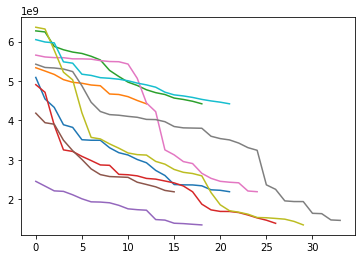

In [4]:
NUMINITS = 10
init_list = []
descending_wall_list = []
descending_cost_list = []
x_opt_list = []

plt.figure()
for init_i in range(NUMINITS):

    start_time = time.time()

    #for ws in np.linspace(0,163,16):
    #	for we in np.linspace(ws+10.866,163,int((163-(ws+10.866))/11)):
    #		for wh in np.linspace(0.1,5,10):

    #wall_init = [40.,60.,1.0]
    heights_init = np.random.uniform(low = 0.0, high = 5.0, size = 8)
    #x_opt = scipy.optimize.minimize(objective2, heights_init, method='Nelder-Mead', tol = 10.0e5, options = {'disp': True, 'return_all': True})
    #print(x_opt) 

    heights_temp = heights_init.copy()
    heights_min = heights_temp.copy()
    cost_temp = objective2(heights_temp)
    cost_min = cost_temp
    epoch_min_prev = heights_init.copy()
    min_store = []
    heights_store = []


    hvals = np.linspace(0,5.0,31)
    for epoch in range(10):
        print("-------------epoch--------------\n"+str(epoch))
        for index in range(8):
            heights_temp = heights_min.copy()
            for j, h_val in enumerate(hvals):
                heights_temp[index] = h_val
                cost_temp = objective2(heights_temp)
                if cost_temp < cost_min:
                    cost_min = cost_temp
                    print("new min")
                    heights_min[index] = h_val    
                    min_store.append(cost_min)
                    heights_store.append(heights_min.copy())
                print(heights_temp)
                print(heights_min)
        if np.array_equal(epoch_min_prev,heights_min):
            break
        epoch_min_prev = heights_min.copy()
    print(heights_min)

    plt.plot(range(len(min_store)),min_store)
    


    #if total_cost_new < total_cost:
    #	total_cost  = total_cost_new
    #	cost_opt 	= np.append(cost_opt,total_cost_new)
    #	x_opt	  	= np.concatenate((x_opt,x))

    elapsed_time = time.time() - start_time
    print("Elapsed Time: ",elapsed_time, "sec")

plt.savefig('coordloop.png')